In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [2]:
# Data directories
data_dir = 'coal_data'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [3]:
# Create datasets
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(val_dir, data_transforms['val'])
}

# Create data loaders
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=4)
}

# Dataset sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"Class names: {class_names}")
print(f"Training samples: {dataset_sizes['train']}")
print(f"Validation samples: {dataset_sizes['val']}")


Class names: ['Defect_coal', 'Good_quality_coal']
Training samples: 378
Validation samples: 26


In [4]:

# Function to display sample images
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')


Sample training images:


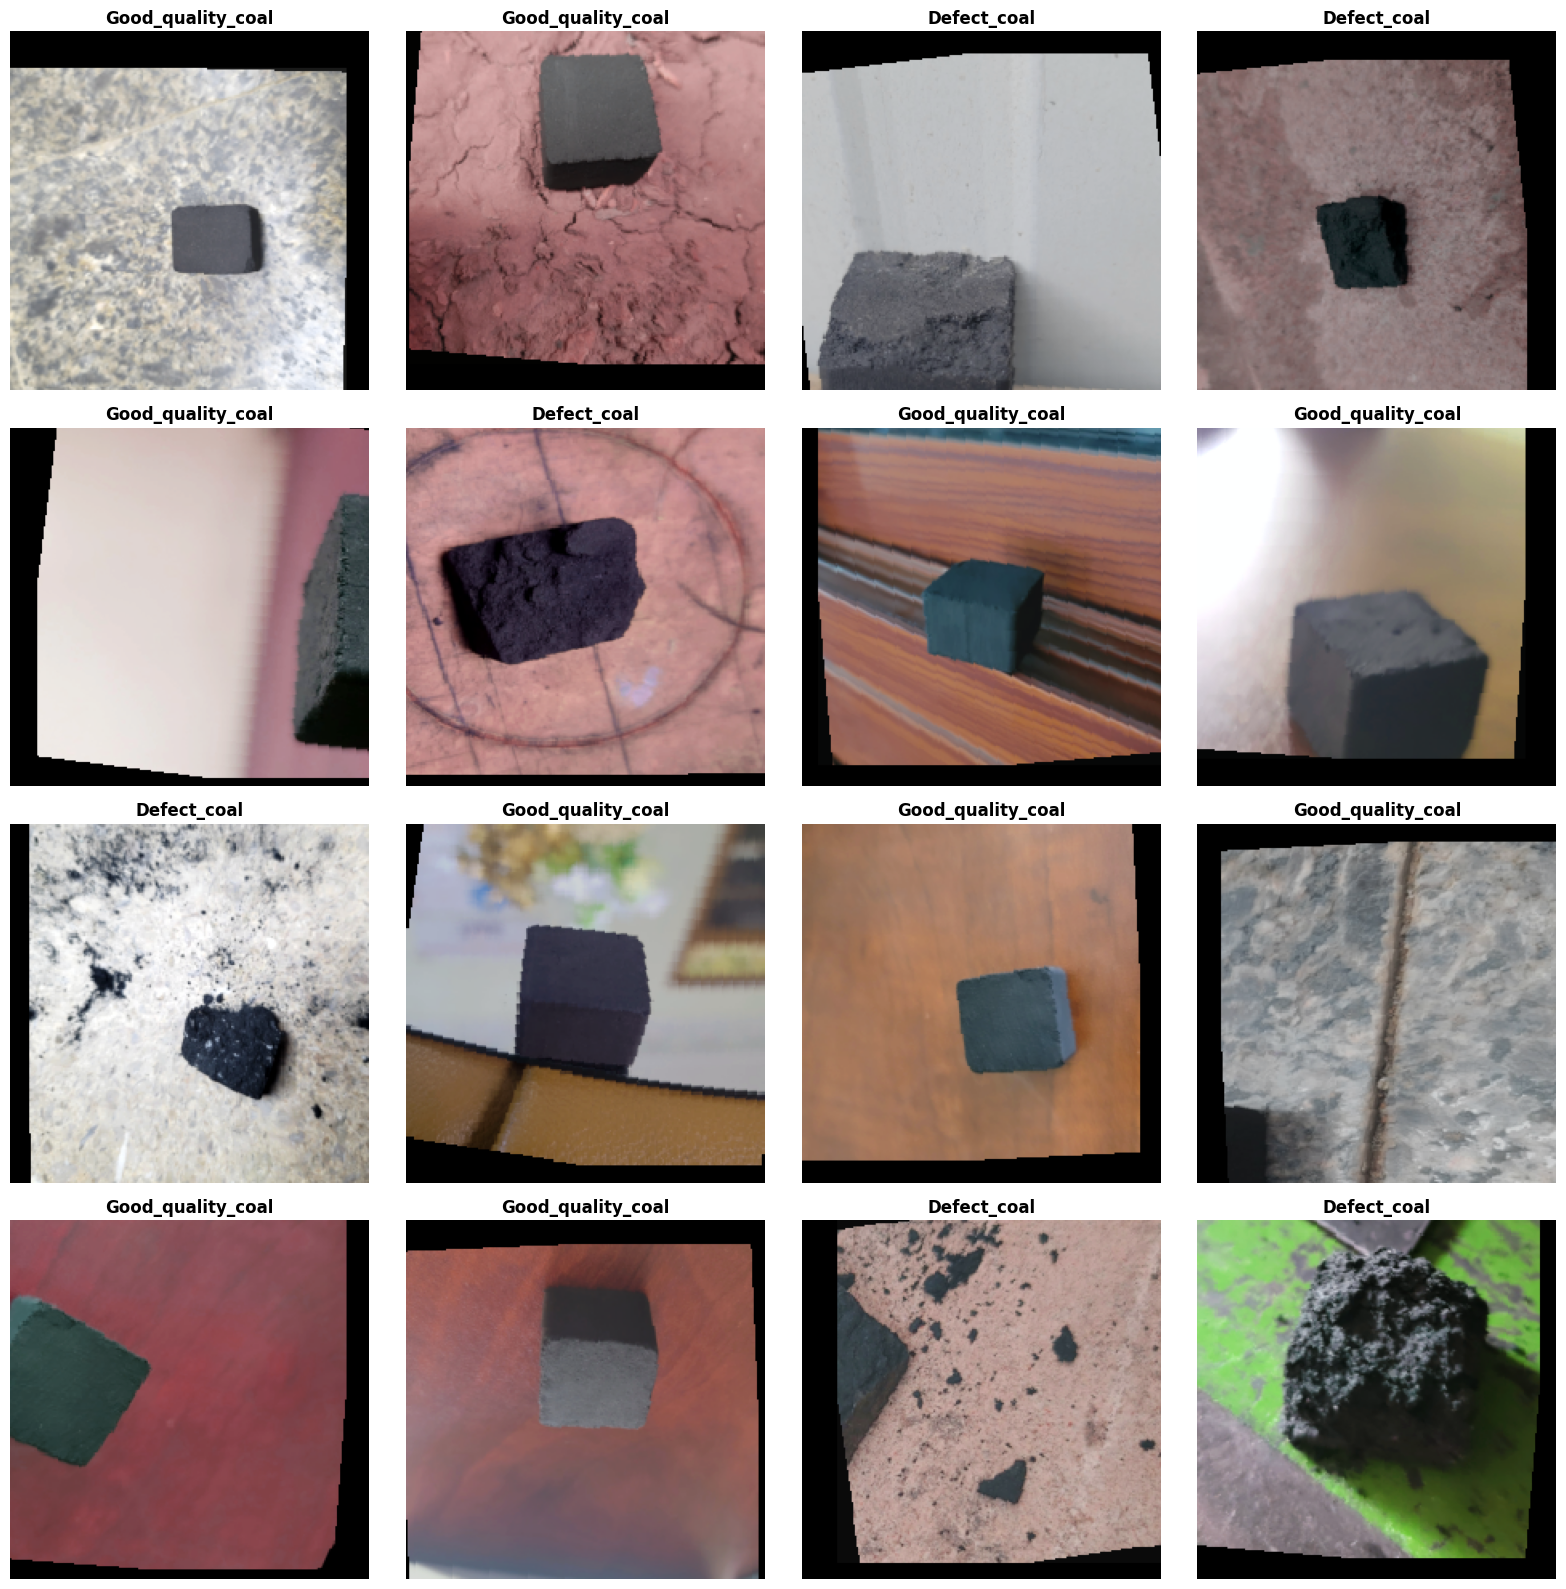


Detailed view of sample images:


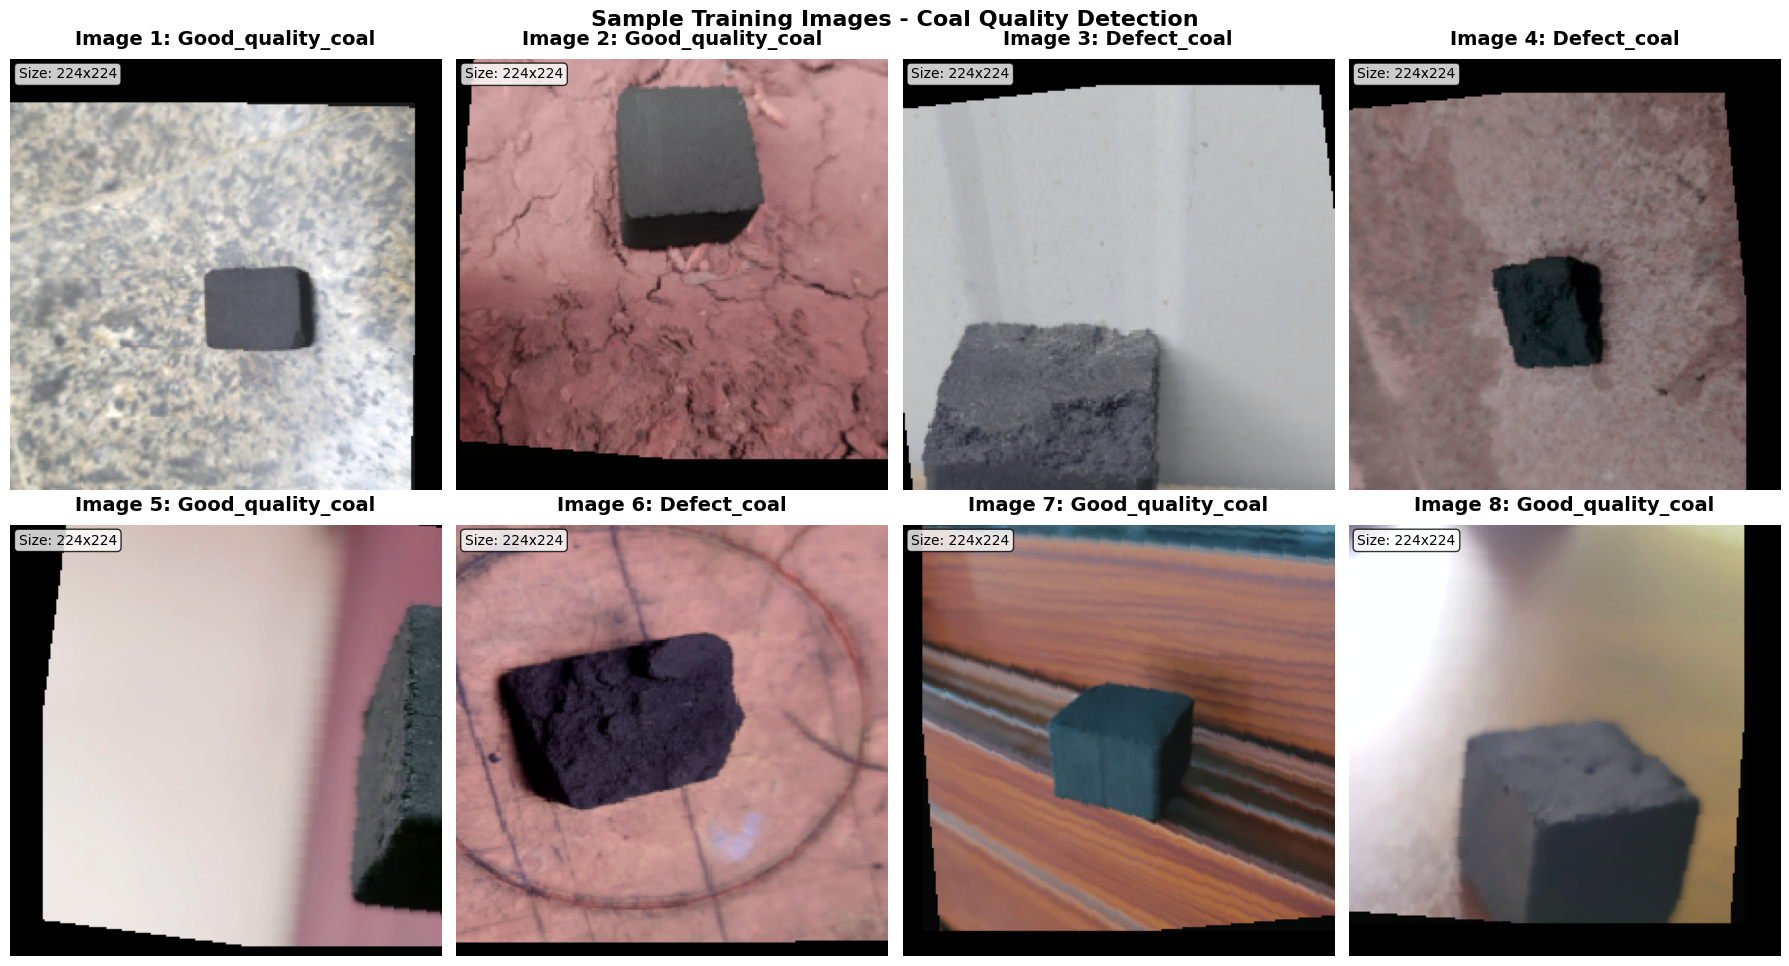


Examples by class:


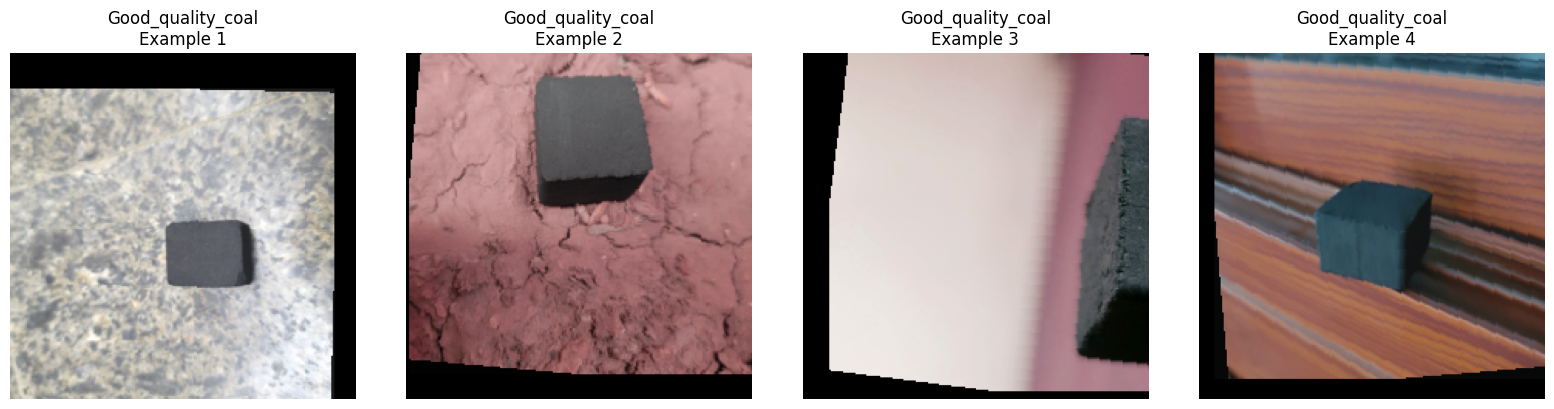

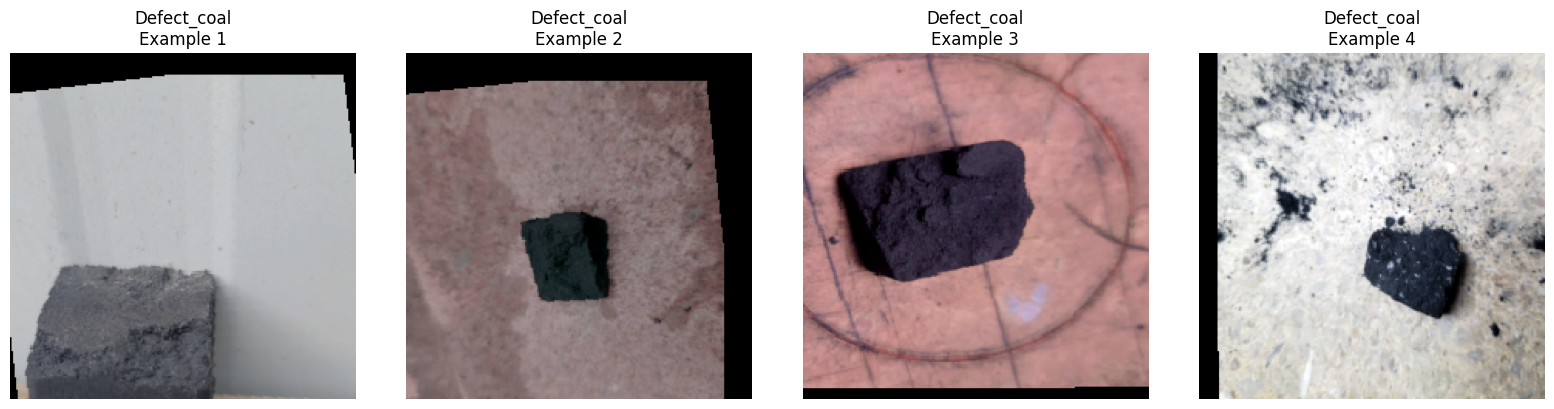

In [6]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Display sample images in a clear grid layout
def show_batch_grid(inputs, classes, class_names, num_images=16):
    """
    Display images in a clear grid layout with one image next to another
    """
    # Limit to num_images to avoid overcrowding
    if len(inputs) > num_images:
        inputs = inputs[:num_images]
        classes = classes[:num_images]
    
    # Calculate grid dimensions
    num_images = len(inputs)
    cols = 4  # Number of columns in the grid
    rows = (num_images + cols - 1) // cols  # Calculate required rows
    
    # Create figure with appropriate size
    fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
    
    # Handle case when there's only one row
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    # Flatten axes for easy iteration
    axes = axes.flatten()
    
    for idx in range(num_images):
        img = inputs[idx]
        label = classes[idx]
        
        # Convert tensor to numpy and denormalize
        img = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        # Display image
        axes[idx].imshow(img)
        axes[idx].set_title(f'{class_names[label]}', fontsize=12, fontweight='bold')
        axes[idx].axis('off')
    
    # Hide any unused subplots
    for idx in range(num_images, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display the batch in a clear grid
print("Sample training images:")
show_batch_grid(inputs, classes, class_names, num_images=16)

# Alternative version with larger images and better spacing
def show_batch_detailed(inputs, classes, class_names, num_images=8):
    """
    Display fewer images but with larger size and more details
    """
    if len(inputs) > num_images:
        inputs = inputs[:num_images]
        classes = classes[:num_images]
    
    num_images = len(inputs)
    cols = 4
    rows = (num_images + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
    
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    axes = axes.flatten()
    
    for idx in range(num_images):
        img = inputs[idx]
        label = classes[idx]
        
        # Convert and denormalize
        img = img.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        
        # Display image
        axes[idx].imshow(img)
        
        # Add title with class name and index
        axes[idx].set_title(f'Image {idx+1}: {class_names[label]}', 
                          fontsize=14, fontweight='bold', pad=10)
        axes[idx].axis('off')
        
        # Add some image statistics
        height, width = img.shape[:2]
        axes[idx].text(0.02, 0.98, f'Size: {width}x{height}', 
                      transform=axes[idx].transAxes, 
                      fontsize=10, verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Hide unused subplots
    for idx in range(num_images, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)  # Adjust top to make space for title
    plt.suptitle('Sample Training Images - Coal Quality Detection', 
                fontsize=16, fontweight='bold', y=0.98)
    plt.show()

# Display detailed view
print("\nDetailed view of sample images:")
show_batch_detailed(inputs, classes, class_names, num_images=8)

# Show both good and defective examples separately
def show_class_examples(inputs, classes, class_names):
    """
    Show examples from each class separately
    """
    # Separate images by class
    class_indices = {}
    for i, class_idx in enumerate(classes):
        if class_idx.item() not in class_indices:
            class_indices[class_idx.item()] = []
        class_indices[class_idx.item()].append(i)
    
    # Display examples for each class
    for class_idx, indices in class_indices.items():
        class_name = class_names[class_idx]
        num_examples = min(4, len(indices))  # Show up to 4 examples per class
        
        fig, axes = plt.subplots(1, num_examples, figsize=(16, 4))
        
        # Handle single image case
        if num_examples == 1:
            axes = [axes]
        
        for i, idx in enumerate(indices[:num_examples]):
            img = inputs[idx]
            
            # Convert and denormalize
            img = img.numpy().transpose((1, 2, 0))
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)
            
            axes[i].imshow(img)
            axes[i].set_title(f'{class_name}\nExample {i+1}', fontsize=12)
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()

# Display examples by class
print("\nExamples by class:")
show_class_examples(inputs, classes, class_names)

Training Images - Clear Grid Layout


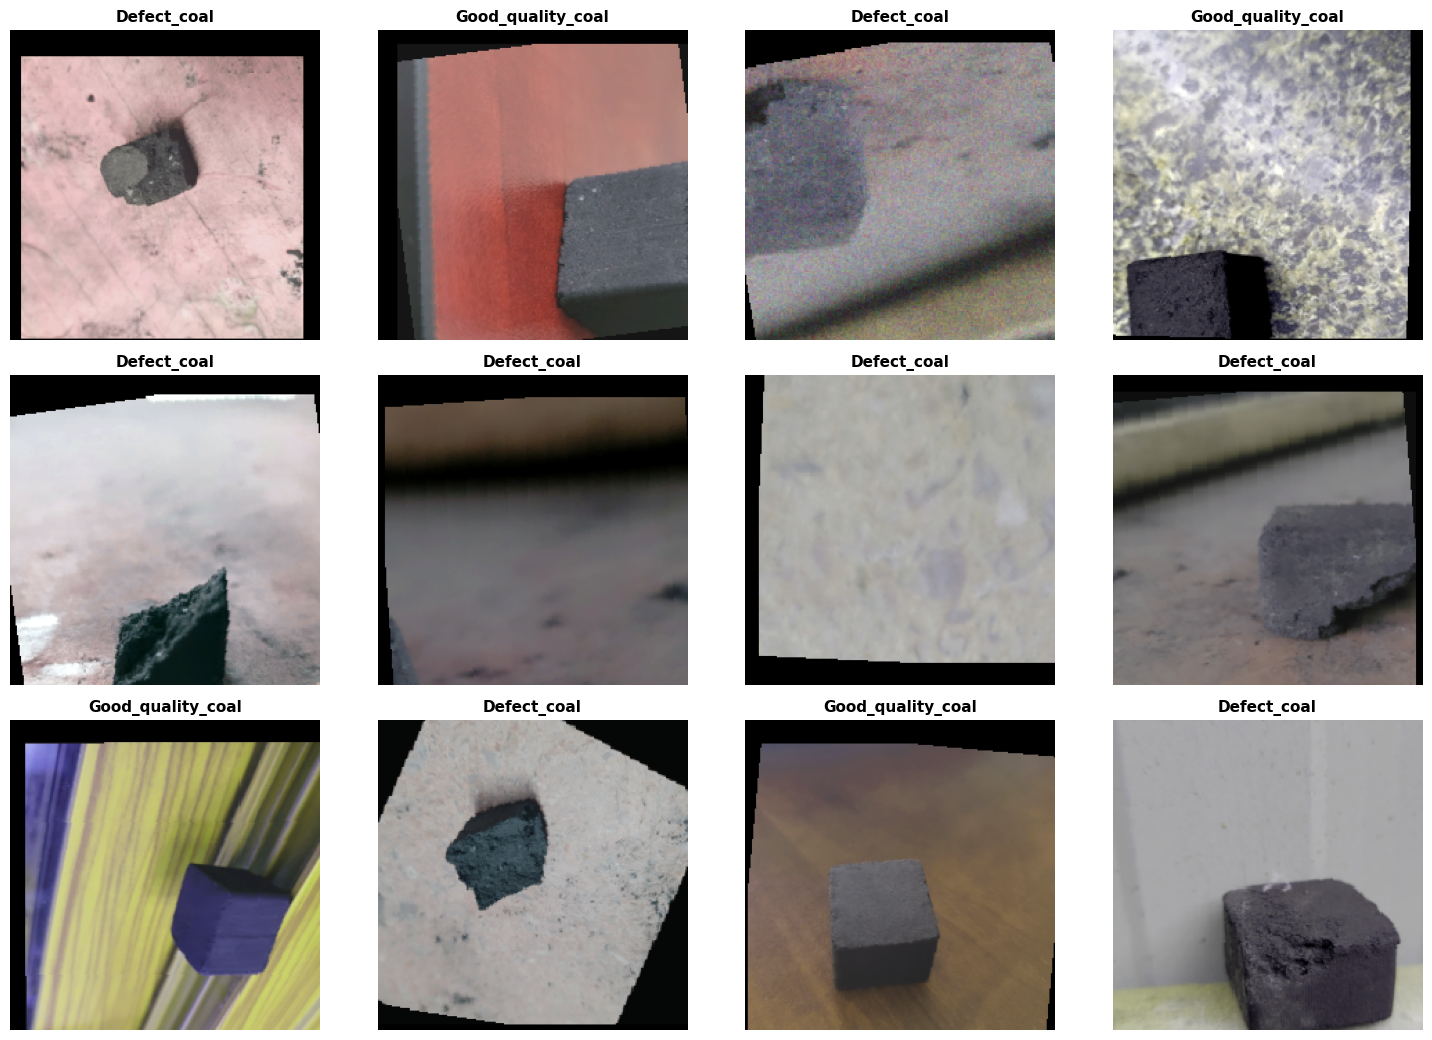

In [7]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Simple and clean grid display
def show_clean_grid(inputs, classes, class_names, num_images=12):
    """
    Clean grid layout with images displayed one next to another
    """
    if len(inputs) > num_images:
        inputs = inputs[:num_images]
        classes = classes[:num_images]
    
    num_images = len(inputs)
    cols = 4
    rows = (num_images + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3.5 * rows))
    
    # Handle single row/column cases
    if rows == 1:
        axes = axes.reshape(1, -1)
    if cols == 1:
        axes = axes.reshape(-1, 1)
    
    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            if idx < num_images:
                img = inputs[idx]
                label = classes[idx]
                
                # Convert tensor to numpy and denormalize
                img = img.numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                
                axes[i, j].imshow(img)
                axes[i, j].set_title(f'{class_names[label]}', fontsize=11, fontweight='bold')
                axes[i, j].axis('off')
            else:
                axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Display the clean grid
print("Training Images - Clear Grid Layout")
show_clean_grid(inputs, classes, class_names, num_images=12)

In [8]:
# Load pre-trained ResNet model
model = models.resnet50(pretrained=True)

# Freeze all layers except the final layer
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, 256),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3),
    nn.Linear(256, len(class_names))
)

model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Only parameters of final layer are being optimized
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [9]:


# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Track training history
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Track history
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.cpu().numpy())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.cpu().numpy())

            # Deep copy the model if it's the best so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Training Accuracy')
    plt.plot(val_acc_history, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model, train_loss_history, train_acc_history, val_loss_history, val_acc_history


Starting training...
Epoch 0/24
----------
train Loss: 0.6857 Acc: 0.6481
val Loss: 0.4576 Acc: 0.7308

Epoch 1/24
----------
train Loss: 0.4688 Acc: 0.7646
val Loss: 0.2092 Acc: 0.9231

Epoch 2/24
----------
train Loss: 0.4422 Acc: 0.7937
val Loss: 0.1549 Acc: 0.9231

Epoch 3/24
----------
train Loss: 0.3780 Acc: 0.8307
val Loss: 0.1254 Acc: 0.9615

Epoch 4/24
----------
train Loss: 0.3026 Acc: 0.8836
val Loss: 0.1023 Acc: 0.9615

Epoch 5/24
----------
train Loss: 0.2859 Acc: 0.8968
val Loss: 0.1122 Acc: 0.9615

Epoch 6/24
----------
train Loss: 0.2753 Acc: 0.8836
val Loss: 0.0860 Acc: 0.9615

Epoch 7/24
----------
train Loss: 0.2493 Acc: 0.8942
val Loss: 0.0999 Acc: 0.9615

Epoch 8/24
----------
train Loss: 0.1844 Acc: 0.9180
val Loss: 0.1085 Acc: 0.9615

Epoch 9/24
----------
train Loss: 0.2215 Acc: 0.9101
val Loss: 0.1048 Acc: 0.9615

Epoch 10/24
----------
train Loss: 0.2416 Acc: 0.9101
val Loss: 0.0829 Acc: 0.9615

Epoch 11/24
----------
train Loss: 0.2375 Acc: 0.9127
val Loss: 0

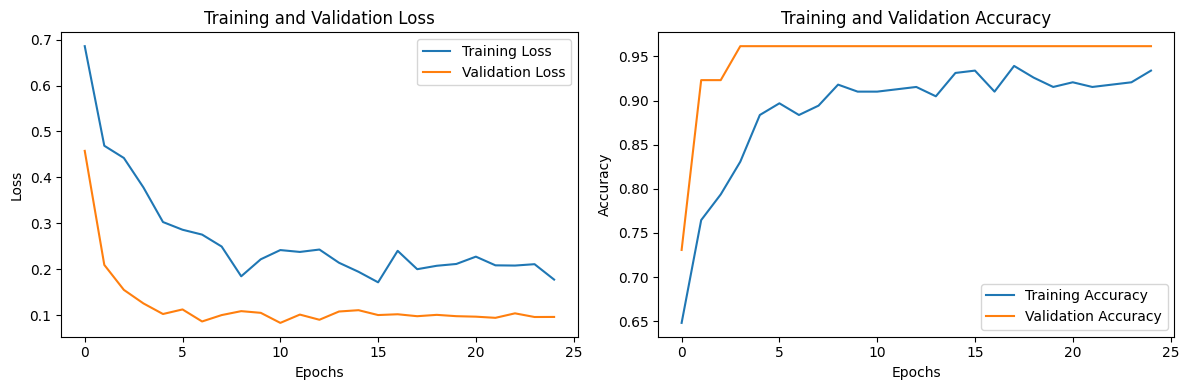

In [10]:

# Train the model
print("Starting training...")
model, train_loss, train_acc, val_loss, val_acc = train_model(
    model, criterion, optimizer, exp_lr_scheduler, num_epochs=25
)


In [11]:

# Save the trained model
torch.save(model.state_dict(), 'coal_quality_model.pth')
print("Model saved as 'coal_quality_model.pth'")


Model saved as 'coal_quality_model.pth'


In [12]:

# Function to test the model on a single image
def predict_coal_quality(image_path, model, class_names):
    """
    Predict whether a coal cube is good or defective
    
    Args:
        image_path (str): Path to the image file
        model: Trained PyTorch model
        class_names: List of class names
    
    Returns:
        dict: Prediction results
    """
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    
    # Apply validation transforms
    preprocess = data_transforms['val']
    image_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension
    
    # Move to device
    image_tensor = image_tensor.to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    # Make prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    # Get results
    predicted_class = class_names[predicted.item()]
    confidence_score = confidence.item()
    
    # Display the image and prediction
    plt.figure(figsize=(8, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Predicted: {predicted_class}\nConfidence: {confidence_score:.4f}')
    
    # Show probabilities
    plt.subplot(1, 2, 2)
    probs = probabilities.cpu().numpy()[0]
    colors = ['red' if x == predicted.item() else 'blue' for x in range(len(class_names))]
    bars = plt.bar(class_names, probs, color=colors)
    plt.title('Class Probabilities')
    plt.xticks(rotation=45)
    plt.ylabel('Probability')
    
    # Add probability values on bars
    for bar, prob in zip(bars, probs):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{prob:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'predicted_class': predicted_class,
        'confidence': confidence_score,
        'all_probabilities': {class_names[i]: float(probs[i]) for i in range(len(class_names))}
    }

# Test the model with a sample image
def test_model_with_image(image_path):
    """
    Test the trained model with a single image
    """
    if not os.path.exists(image_path):
        print(f"Error: Image path '{image_path}' does not exist!")
        return None
    
    print(f"Testing model with image: {image_path}")
    result = predict_coal_quality(image_path, model, class_names)
    
    print("\n" + "="*50)
    print("PREDICTION RESULTS:")
    print("="*50)
    print(f"Predicted Class: {result['predicted_class']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print("\nAll Probabilities:")
    for class_name, prob in result['all_probabilities'].items():
        print(f"  {class_name}: {prob:.4f}")
    print("="*50)
    
    return result

# Example usage:
# You can test the model by providing an image path
# test_model_with_image('path/to/your/coal/image.jpg')

# Load the saved model for future use (optional)
def load_trained_model(model_path, class_names):
    """
    Load a trained model for inference
    """
    model = models.resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(num_ftrs, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.3),
        nn.Linear(256, len(class_names))
    )
    
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    
    return model

# Example of how to use the loaded model:
# loaded_model = load_trained_model('coal_quality_model.pth', class_names)
# result = test_model_with_image('path/to/test/image.jpg')

Testing model with image: E:\AI Deep learning\coal_project\new_coal_pic.jpeg


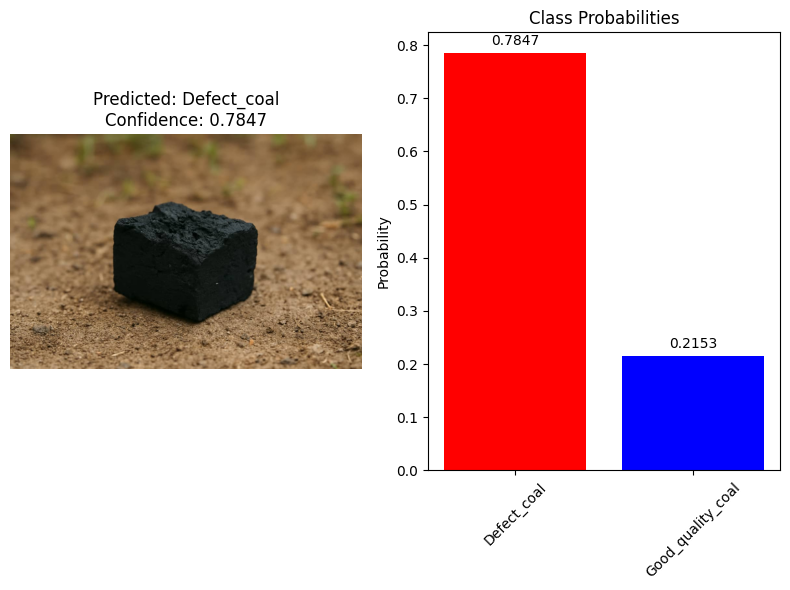


PREDICTION RESULTS:
Predicted Class: Defect_coal
Confidence: 0.7847

All Probabilities:
  Defect_coal: 0.7847
  Good_quality_coal: 0.2153


In [14]:
# Test the model with your image
image_path = r"E:\AI Deep learning\coal_project\new_coal_pic.jpeg"  # Replace with your image path
result = test_model_with_image(image_path)

Testing model with image: E:\AI Deep learning\coal_project\coal_data\train\Defect_coal\20251012_094001.jpg


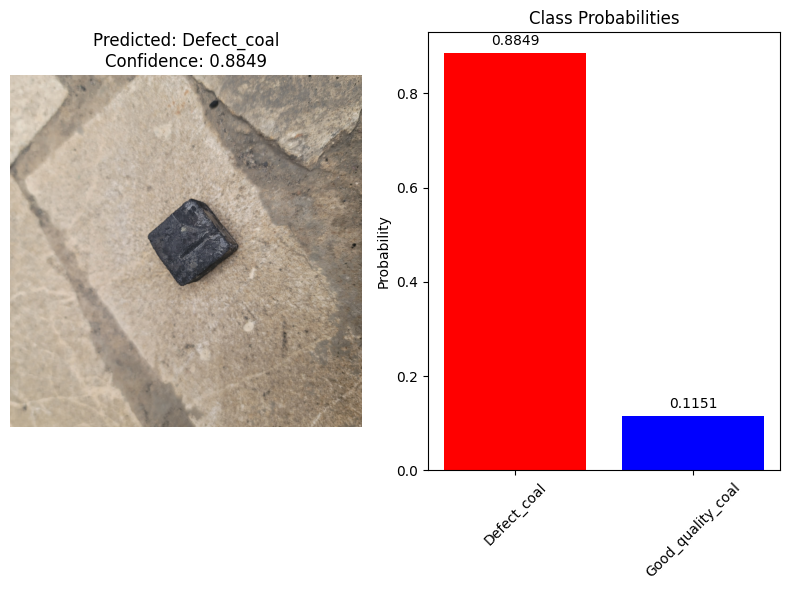


PREDICTION RESULTS:
Predicted Class: Defect_coal
Confidence: 0.8849

All Probabilities:
  Defect_coal: 0.8849
  Good_quality_coal: 0.1151


In [15]:
# Test the model with your image
image_path = r"E:\AI Deep learning\coal_project\coal_data\train\Defect_coal\20251012_094001.jpg"  # Replace with your image path
result = test_model_with_image(image_path)

Testing model with image: E:\AI Deep learning\coal_project\coal_data\val\Good_quality_coal\20251012_100817.jpg


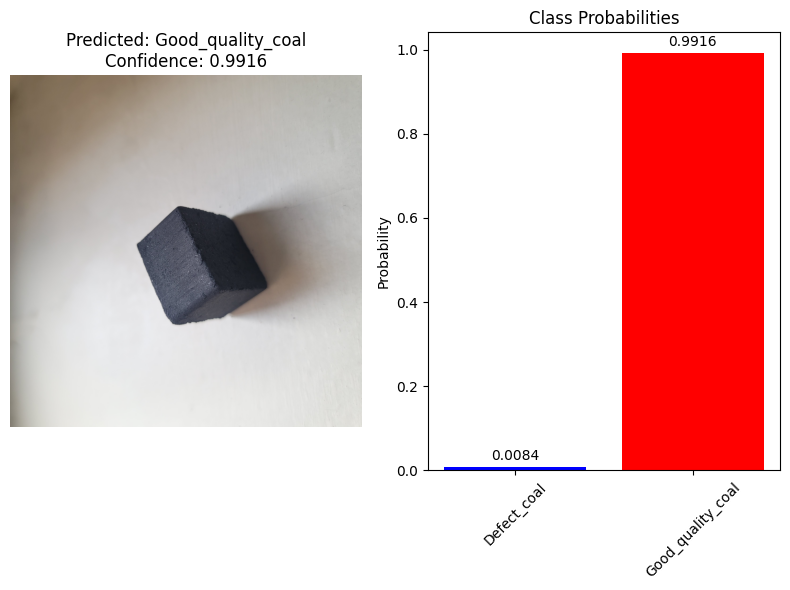


PREDICTION RESULTS:
Predicted Class: Good_quality_coal
Confidence: 0.9916

All Probabilities:
  Defect_coal: 0.0084
  Good_quality_coal: 0.9916


In [16]:
# Test the model with your image
image_path = r"E:\AI Deep learning\coal_project\coal_data\val\Good_quality_coal\20251012_100817.jpg"  # Replace with your image path
result = test_model_with_image(image_path)

Testing model with image: E:\AI Deep learning\coal_project\coal_data\val\Defect_coal\20251012_095409.jpg


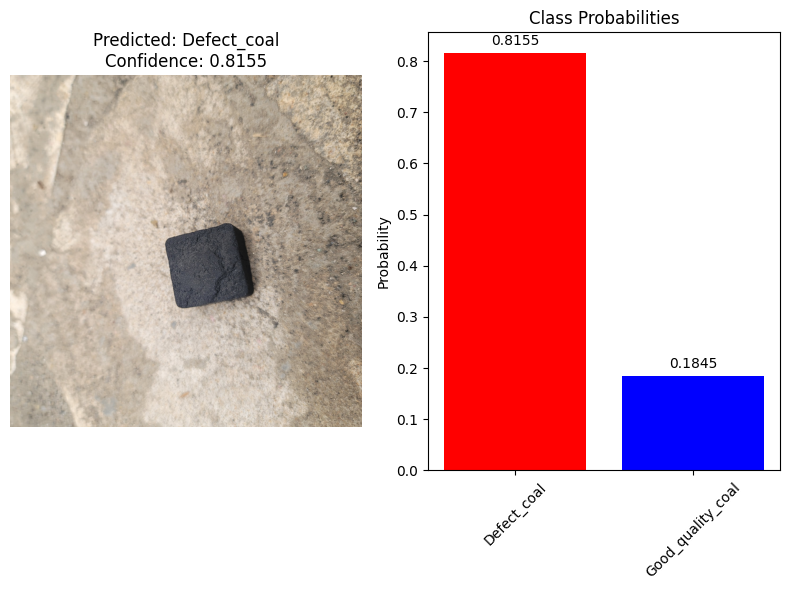


PREDICTION RESULTS:
Predicted Class: Defect_coal
Confidence: 0.8155

All Probabilities:
  Defect_coal: 0.8155
  Good_quality_coal: 0.1845


In [18]:
# Test the model with your image
image_path = r"E:\AI Deep learning\coal_project\coal_data\val\Defect_coal\20251012_095409.jpg"  # Replace with your image path
result = test_model_with_image(image_path)

Testing model with image: E:\AI Deep learning\coal_project\coal_data\val\Good_quality_coal\20251012_100650.jpg


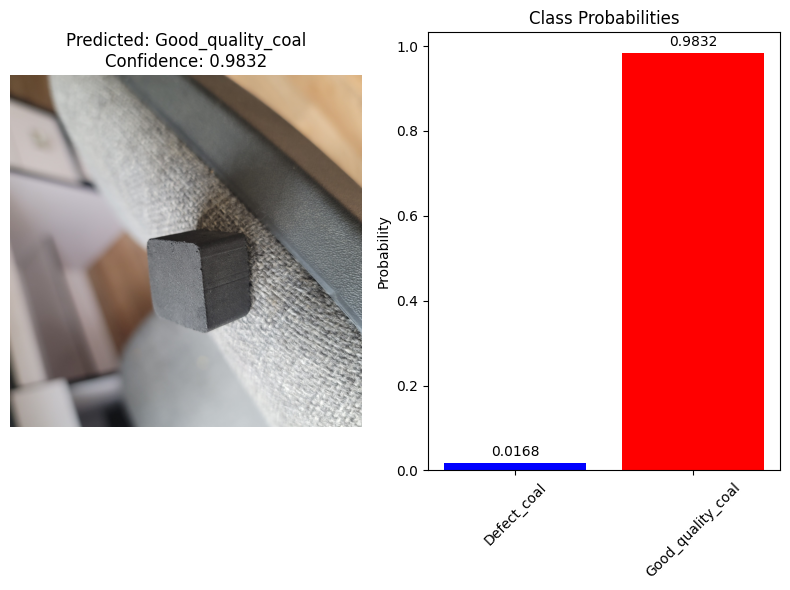


PREDICTION RESULTS:
Predicted Class: Good_quality_coal
Confidence: 0.9832

All Probabilities:
  Defect_coal: 0.0168
  Good_quality_coal: 0.9832


In [19]:
# Test the model with your image
image_path = r"E:\AI Deep learning\coal_project\coal_data\val\Good_quality_coal\20251012_100650.jpg"  # Replace with your image path
result = test_model_with_image(image_path)

Testing model with image: E:\AI Deep learning\coal_project\project2_largdata_coal\livepic.jpg


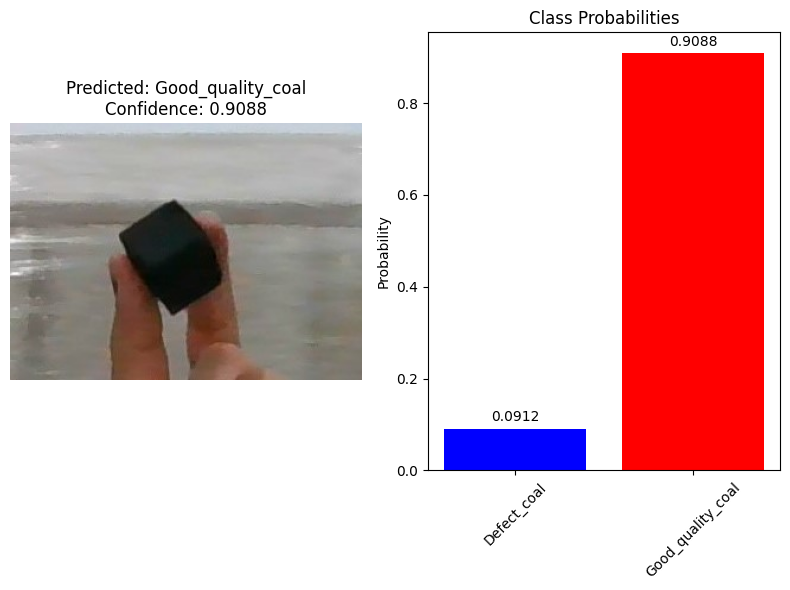


PREDICTION RESULTS:
Predicted Class: Good_quality_coal
Confidence: 0.9088

All Probabilities:
  Defect_coal: 0.0912
  Good_quality_coal: 0.9088


In [20]:
# Test the model with your image
image_path = r"E:\AI Deep learning\coal_project\project2_largdata_coal\livepic.jpg"  # Replace with your image path
result = test_model_with_image(image_path)